In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, accuracy_score
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

## Reading and Preprocessing the Dataset

In [6]:
soil = pd.read_csv('dataset/soilmoisture_dataset.csv')
soil.head()

,index,datetime,soil_moisture,soil_temperature,454,458,462,466,470,474,...,914,918,922,926,930,934,938,942,946,950
0,0,2017-05-23 14:06:17,33.51,34.8,0.082131,0.055863,0.050047,0.047925,0.047498,0.046464,...,0.152845,0.152615,0.152927,0.154240,0.155018,0.154725,0.154682,0.154275,0.153477,0.153929
1,1,2017-05-23 14:08:17,33.49,35.2,0.079510,0.055326,0.049116,0.047579,0.046745,0.046833,...,0.152715,0.153102,0.153551,0.153590,0.153688,0.153370,0.154021,0.155543,0.156220,0.156727
2,2,2017-05-23 14:10:17,33.46,35.4,0.080599,0.054065,0.049150,0.047537,0.046525,0.046032,...,0.152362,0.152158,0.153204,0.153942,0.154610,0.154629,0.155609,0.155545,0.154884,0.154485
3,3,2017-05-23 14:12:17,33.33,35.0,0.078024,0.054972,0.049052,0.047920,0.046883,0.046775,...,0.153281,0.153990,0.154499,0.155012,0.154691,0.154643,0.155405,0.155918,0.157645,0.157824
4,4,2017-05-23 14:14:17,33.32,35.3,0.079973,0.055335,0.049314,0.047373,0.047028,0.046963,...,0.152803,0.153085,0.153295,0.154230,0.155071,0.155624,0.156504,0.156859,0.156634,0.156176


In [7]:
X = soil.drop(['index', 'datetime'], axis=1)
X.head()

,soil_moisture,soil_temperature,454,458,462,466,470,474,478,482,...,914,918,922,926,930,934,938,942,946,950
0,33.51,34.8,0.082131,0.055863,0.050047,0.047925,0.047498,0.046464,0.046669,0.046834,...,0.152845,0.152615,0.152927,0.154240,0.155018,0.154725,0.154682,0.154275,0.153477,0.153929
1,33.49,35.2,0.079510,0.055326,0.049116,0.047579,0.046745,0.046833,0.046329,0.047021,...,0.152715,0.153102,0.153551,0.153590,0.153688,0.153370,0.154021,0.155543,0.156220,0.156727
2,33.46,35.4,0.080599,0.054065,0.049150,0.047537,0.046525,0.046032,0.046276,0.046886,...,0.152362,0.152158,0.153204,0.153942,0.154610,0.154629,0.155609,0.155545,0.154884,0.154485
3,33.33,35.0,0.078024,0.054972,0.049052,0.047920,0.046883,0.046775,0.046835,0.046996,...,0.153281,0.153990,0.154499,0.155012,0.154691,0.154643,0.155405,0.155918,0.157645,0.157824
4,33.32,35.3,0.079973,0.055335,0.049314,0.047373,0.047028,0.046963,0.046763,0.047051,...,0.152803,0.153085,0.153295,0.154230,0.155071,0.155624,0.156504,0.156859,0.156634,0.156176


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Defining the Utility Functions

For creating the Hierarchical Cluster

In [9]:
def get_distances(X, model, mode='l2'):
    """
    Popular solution to plot HCs here https://stackoverflow.com/a/12311782/2096747
    """
    distances = []
    weights = []
    children=model.children_
    dims = (X.shape[1],1)
    distCache = {}
    weightCache = {}
    for childs in children:
        c1 = X[childs[0]].reshape(dims)
        c2 = X[childs[1]].reshape(dims)
        c1Dist = 0
        c1W = 1
        c2Dist = 0
        c2W = 1
        if childs[0] in distCache.keys():
            c1Dist = distCache[childs[0]]
            c1W = weightCache[childs[0]]
        if childs[1] in distCache.keys():
            c2Dist = distCache[childs[1]]
            c2W = weightCache[childs[1]]
        d = np.linalg.norm(c1-c2)
        cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

        X = np.vstack((X,cc.T))

        newChild_id = X.shape[0]-1

        # How to deal with a higher level cluster merge with lower distance:
        if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
            added_dist = (c1Dist**2+c2Dist**2)**0.5 
            dNew = (d**2 + added_dist**2)**0.5
        elif mode == 'max':  # If the previrous clusters had higher distance, use that one
            dNew = max(d,c1Dist,c2Dist)
        elif mode == 'actual':  # Plot the actual distance.
            dNew = d

        wNew = (c1W + c2W)
        distCache[newChild_id] = dNew
        weightCache[newChild_id] = wNew

        distances.append(dNew)
        weights.append( wNew)
    return distances, weights

For plotting the Hierarchical Cluster

In [13]:
def plot_test(model, title, **kwargs):
    distance, weight = get_distances(X,model)
    linkage_matrix = np.column_stack([model.children_, distance, weight]).astype(float)
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Clusters', fontsize=18)
    plt.ylabel('Similarity (0 when max)', fontsize=16)
    shc.dendrogram(linkage_matrix, **kwargs)
    plt.show()

For determining the silhouette scores for any given estimator that implements the `fit_predictor` method present in `sklearn`.

In [28]:
def determine_silhouette_scores(k_centers, estimator):
    silhouette_scores = []
    for k in k_centers:
        y_pred = estimator(k, X)
        score = round(silhouette_score(X, y_pred, metric='euclidean'), 4)
        silhouette_scores.append(score)
    return silhouette_scores

For determining the WSS error with the Elbow method.

In [78]:
def determine_elbow_results(k_centers, X):
    distortions = []
    for k in k_centers:
        cluster = KMeans(n_clusters=k)
        cluster.fit(X)
        distortions.append(sum(np.min(cdist(X, cluster.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    return distortions

## Analyzing the Dataset with Hierarchical Clusters

Let's have a look at how the dataset is clusterized when selecting a relatively large number of clusters. Let's try a big number like 30.

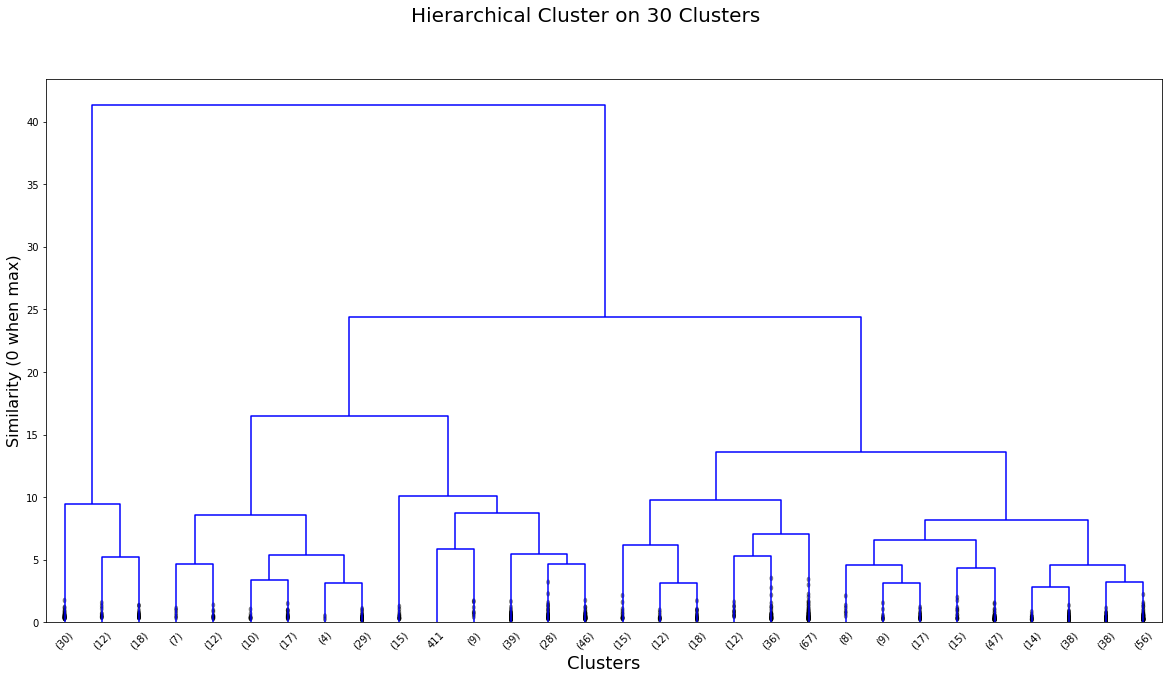

In [14]:
n_clusters = 30
hc = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_hc = hc.fit_predict(X)
plot_title = 'Hierarchical Cluster on ' + str(n_clusters) + ' Clusters'
plot_test(hc, plot_title, count_sort='descending', color_threshold=1, truncate_mode='lastp', 
          p=n_clusters, show_contracted=True, show_leaf_counts=True)

When analyzing the dataset with any sort of clusterized method, we need to decide on the number of clusters we want to end up with. There are a couple of approaches regarding this (both for HC and KMeans):
1. For HC and KMeans: The `silhouette` method. 
1. Just for HC: Looking at HC and deciding which number of clusters separates the best the dataset.
1. Just for KMeans: The `elbow` method.

The linkage criterion we're going with is the default one - `ward`. We shall not be using any other criterion.

In our case, when looking at the above hierarchical cluster, we can see the samples sort of pile up at the very bottom of the tree. That's a very good thing because it signifies that data has easily separable blobs of samples. Looking at it as it is, the best number of clusters that separates the data would be with `2` and that's because for `2` we get the longest vertical branches that aren't disturbed by tree splits.

But since the soil can't be divided in just 2 types (there are many more), we are going to look at the longest vertical lines that are still close to where the points are (that means going down in the tree). That number looks like it could be `5` or `6`. We'll go with `6`.

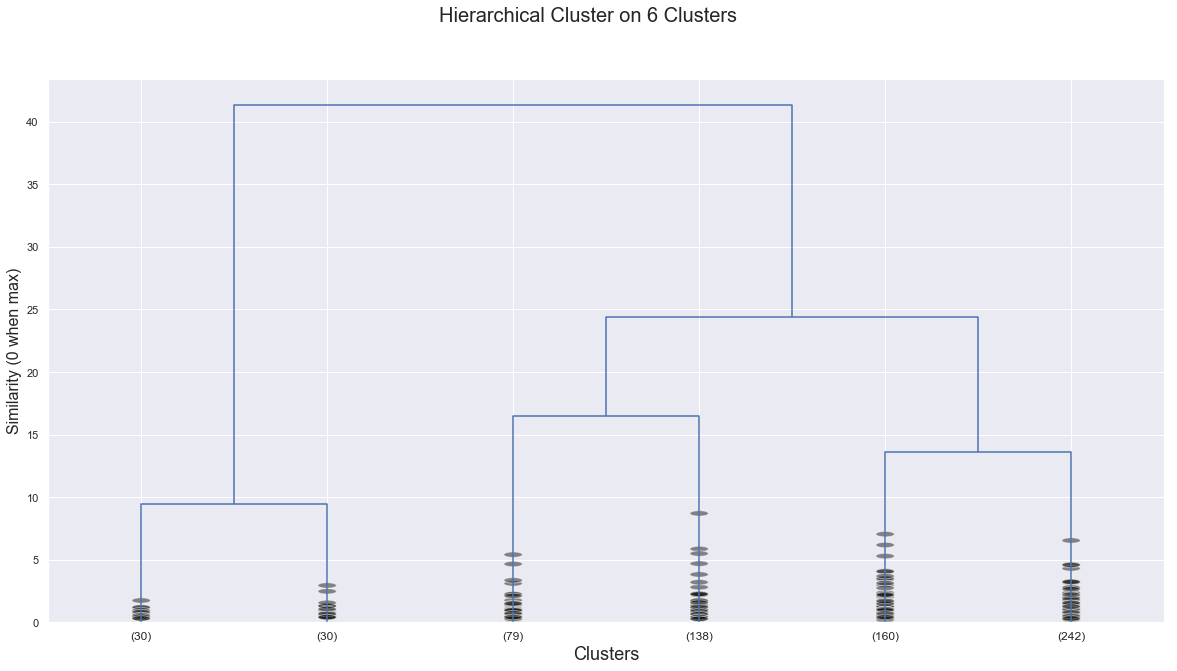

In [76]:
n_clusters = 6
hc = AgglomerativeClustering(n_clusters=n_clusters)
y_pred_hc = hc.fit_predict(X)
plot_title = 'Hierarchical Cluster on ' + str(n_clusters) + ' Clusters'
plot_test(hc, plot_title, count_sort='descending', color_threshold=1, truncate_mode='lastp', 
          p=n_clusters, show_contracted=True, show_leaf_counts=True)

Looking at it above, we see that `6` clusters separate the data quite well. The data points are still quite far from the next upper split in the branch, so there can't be much to ponder when predicting new labels.

In [42]:
k_centers = list(range(2, 21))
silh_scores = determine_silhouette_scores(k_centers, lambda k, X: AgglomerativeClustering(k).fit_predict(X))
silh_scores = pd.DataFrame(np.array([k_centers, silh_scores]).T, columns=['K Clusters', 'Silhouette Score'])

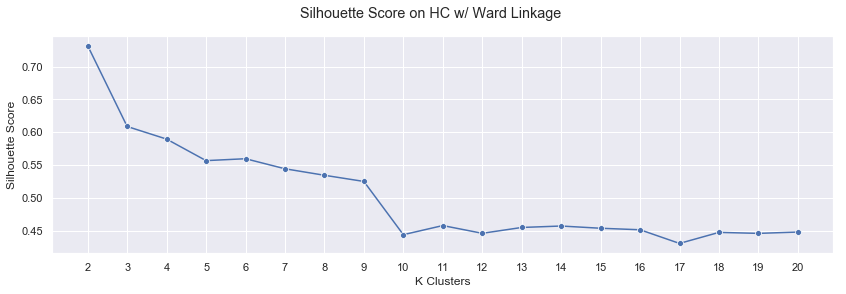

In [77]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Silhouette Score on HC w/ Ward Linkage')
ax = fig.add_subplot(111)
ax.set(xticks=silh_scores['K Clusters'])
sns.lineplot(x='K Clusters', y='Silhouette Score', data=silh_scores, marker='o', ax=ax)

Knowing that the Silhouette range is between `-1` and `1`, `-1` for having a really bad choice of clusters and `1` for having a perfectly separable dataset in the given number of clusters, we look at the above graph. We see that the highest score is achieved when the number of clusters is set to `2`.

Both the visual approach and the Silhouette one tell that the optimal number of clusters is `2`, but since we know there are multiple types of soil, we gotta choose one that's a tradeoff between these 2 criterias. `6` clusters also seem to achieve quite a high score, even slightly higher than with `5` clusters. We also notice that going beyond `9` clusters is going to yield a low score across all higher number of clusters.

## Analyzing the Dataset with KMeans

Now, let's analyze the dataset with the good-ol'-tried KMeans method.

In [80]:
distortions = determine_elbow_results(k_centers, X)
distortions = pd.DataFrame(np.array([k_centers, distortions]).T, columns=['K Clusters', 'Elbow WSS Score'])

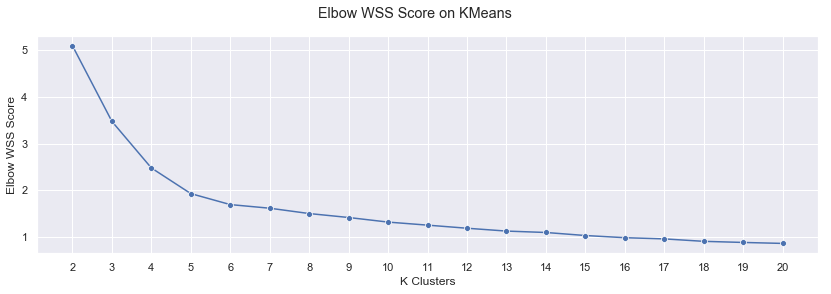

In [84]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Elbow WSS Score on KMeans')
ax = fig.add_subplot(111)
ax.set(xticks=silh_scores['K Clusters'])
sns.lineplot(x='K Clusters', y='Elbow WSS Score', data=distortions, marker='o', ax=ax)

In the above plot we see that the law of diminishing returns starts at a `K` of `6` or `7`. Since we already concluded that `6` is the number of optimal clusters with the HC analysis, we are biased towards thinking that `6` is also okay in this scenario. 

Now, let's have a look at the Silhouette Score with the KMeans clustering method. We will attempt comparing both charts: the one from HC and the one from KMeans.

In [86]:
k_centers = list(range(2, 21))
silh_scores_km = determine_silhouette_scores(k_centers, lambda k, X: KMeans(k).fit_predict(X))
silh_scores_km = pd.DataFrame(np.array([k_centers, silh_scores_km]).T, columns=['K Clusters', 'Silhouette Score'])

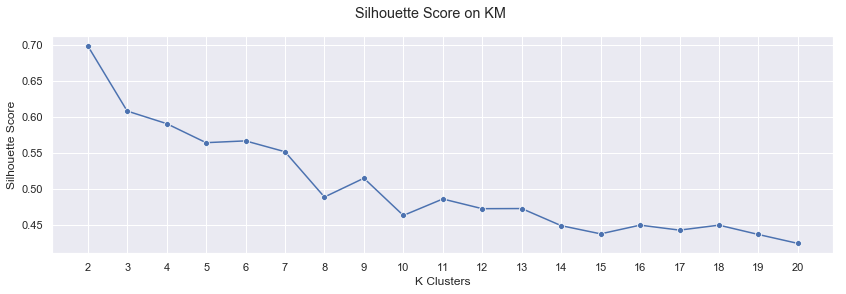

In [87]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Silhouette Score on KM')
ax = fig.add_subplot(111)
ax.set(xticks=silh_scores_km['K Clusters'])
sns.lineplot(x='K Clusters', y='Silhouette Score', data=silh_scores_km, marker='o', ax=ax)

In the above chart we see that setting `6` clusters for this dataset achieves a relatively good score when compared to all other data points in the chart and when taking into consideration the results from the elbow method. `6` clusters still achieve a slightly higher score than with `5` and that's fantastic.

In [101]:
silh_scores['Silhouette Score KMeans'] = silh_scores_km['Silhouette Score']
silh_scores.columns = ['K Clusters', 'Silhouette Score HC', 'Silhouette Score KMeans']

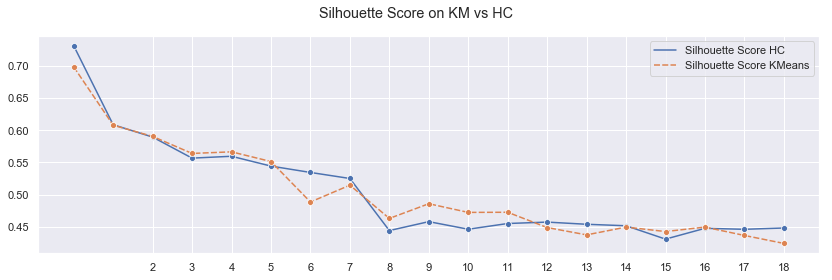

In [109]:
fig = plt.figure(figsize=(14,4))
fig.suptitle('Silhouette Score on KM vs HC')
ax = fig.add_subplot(111)
ax.set(xticks=silh_scores['K Clusters'])
sns.lineplot(data=silh_scores[['Silhouette Score HC', 'Silhouette Score KMeans']], marker='o', ax=ax)

We see that the graphs with the Silhouette scores are almost identical for each clustering method. We can safely judge that selecting `6` clusters for either method is the way to go.